In [292]:
from IPython import get_ipython;   
get_ipython().magic('reset -sf')

2024-03-26 22:11:49.796 | WARNING  | IPython.core.interactiveshell:magic:2569 - DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).


/var/folders/jz/d0qdt29n26309z8ng1hdm6500000gn/T/ipykernel_10432/1502431314.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')


In [293]:
from functools import partial
from pydantic import validate_call
import gdsfactory as gf

In [294]:
import logging
import sys
from functools import partial
from pprint import pprint

import gdsfactory as gf
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import sax
from gdsfactory.generic_tech import get_generic_pdk
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from rich.logging import RichHandler
from scipy import constants
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange

import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH

import pandas as pd

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

gf.config.set_plot_options(show_subports=False)

28.213830820835987
2024-03-26 22:11:57.681 | WARNING  | gdsfactory.component:_write_library:1933 - UserWarning: Component ring_single_b9e4019b has invalid transformations. Try component.flatten_offgrid_references() first.
2024-03-26 22:11:57.691 | INFO     | gdsfactory.technology.layer_views:to_lyp:1017 - LayerViews written to '/var/folders/jz/d0qdt29n26309z8ng1hdm6500000gn/T/gdsfactory/ring_single_b9e4019b.lyp'.


/Users/dingq/miniconda3/lib/python3.11/site-packages/gdsfactory/component.py:1933: UserWarning: Component ring_single_b9e4019b has invalid transformations. Try component.flatten_offgrid_references() first.
  warnings.warn(


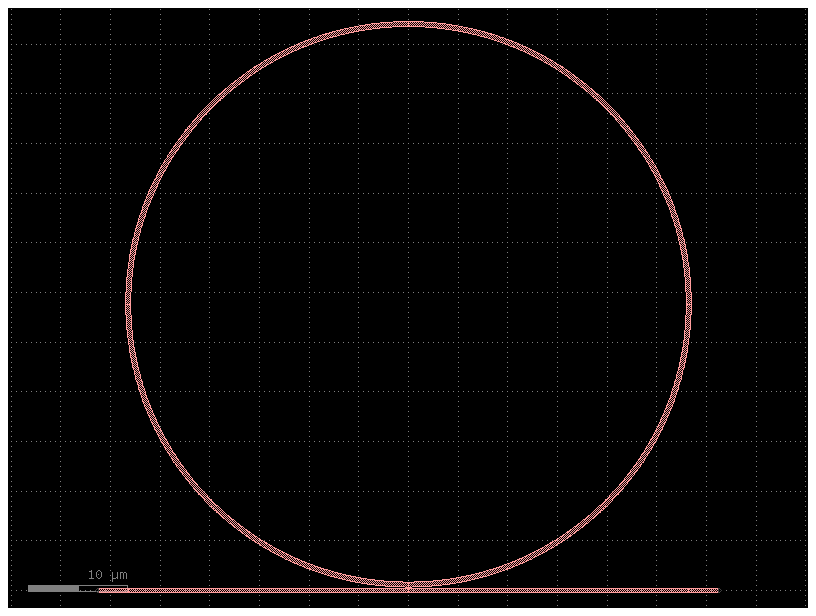

In [295]:
ring_sc = partial(gf.components.ring_single, bend=gf.components.bend_circular, bend_coupler=gf.components.bend_circular, length_x = 0.0, length_y = 0.0)

wl_0 = 0.78
neff_0 = 2.2
m = 500
mrr_r0 = m*wl_0/(2*np.pi*neff_0)
gap_0 = 0.1
print(mrr_r0)

c0 = ring_sc(gap=gap_0, radius=mrr_r0)

c0.plot()

In [274]:
c0.write_netlist("mrr_single_test.yml")


<networkx.classes.graph.Graph object at 0x300ca0c10>

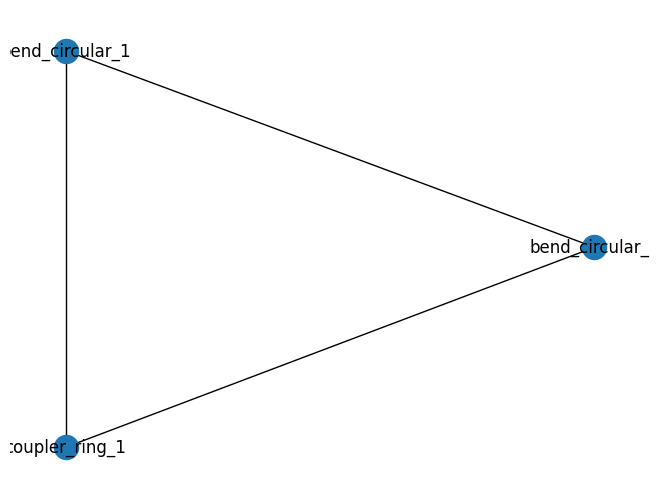

In [275]:
c0.plot_netlist()

In [296]:
mrr_netlist = c0.get_netlist()
pprint(mrr_netlist["connections"])

{'bend_circular_1,o1': 'bend_circular_2,o2',
 'bend_circular_1,o2': 'coupler_ring_1,o2',
 'bend_circular_2,o1': 'coupler_ring_1,o3'}


In [277]:

pprint(mrr_netlist["instances"])

{'bend_circular_1': {'component': 'bend_circular',
                     'info': {'dy': 33.857,
                              'length': 53.182,
                              'radius': 33.856597,
                              'route_info_length': 53.182,
                              'route_info_n_bend_90': 1.0,
                              'route_info_type': 'xs_3c6cb1d2',
                              'route_info_weight': 53.182,
                              'route_info_xs_3c6cb1d2_length': 53.182},
                     'settings': {'angle': 90.0,
                                  'cross_section': {'bbox_layers': None,
                                                    'bbox_offsets': None,
                                                    'components_along_path': [],
                                                    'radius': 33.856597,
                                                    'radius_min': 5.0,
                                                    'sections': [{'hidde

In [ ]:
# define parametrized model

In [297]:
# define analytical models, then run circuit simulation using SAX
bend_loss = 1e-3
tu_0 = 1.0

def bend_circular(wl=wl_0, r0=mrr_r0, neff=neff_0, loss=bend_loss, tuning=tu_0) -> sax.SDict:
    bend_circular_len = 2*r0*np.pi/4
    length = 2*bend_circular_len
    phase = tuning * 2 * jnp.pi * neff * length / wl
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return sax.reciprocal({("o1", "o2"): 
                           #jnp.asarray(10 ** (-loss * length / 20), dtype=complex)*jnp.exp(2j * jnp.pi * neff * length / wl)
                            transmission,
                           })

In [298]:

# define coupler_ring based on modification of coupler

# kappa should depend on the gap size !! --> get an analytical_model on this
#kappa = 
#cp_0 = kappa**2
#tau_sqr = 1 - cp_0
#tau =

#cp_0 = np.exp(-gap_0/wl_0*neff_0)/2
print(gap_0)

def coupler_ring(gap=gap_0) -> sax.SDict:
    coupling = np.exp(-gap/wl_0*neff_0)/2
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    return sax.reciprocal(
        {
            ("o1", "o4"): tau ,
            ("o1", "o3"): 1j * kappa,
            ("o2", "o4"): 1j * kappa,
            ("o2", "o3"): tau,
            #("o2", "o4"): np.conjugate(kappa),
            #("o2", "o3"): np.conjugate(tau),
        }
    )

0.1


In [300]:
# construct circuit with given models

models = {
    "bend_circular": bend_circular,
    "coupler_ring": coupler_ring,
}

mrr_circuit, _ = sax.circuit(netlist=mrr_netlist, models=models)

#print(mrr_circuit(bend_circular={"r0":20.0}, coupler_ring={"gap":0.1}))

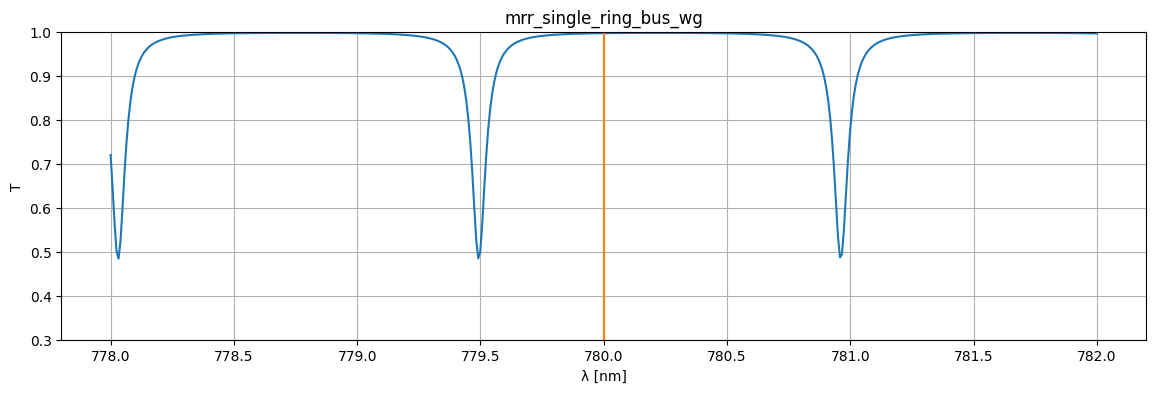

In [301]:
wl_plt = np.linspace(0.778, 0.782, num=500)
guess_r0 = 30.0
S1 = mrr_circuit(wl=wl_plt, bend_circular_1={"r0":guess_r0}, bend_circular_2={"r0":guess_r0},coupler_ring_1={"gap":0.3})

plt.figure(figsize=(14, 4))
plt.title("mrr_single_ring_bus_wg")
plt.plot(1e3 * wl_plt, jnp.abs(S1["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(0.3, 1.0)
plt.plot([780.0, 780.0], [0, 1])
plt.grid(True)
plt.show()

In [310]:
# define loss function

@jax.jit
def loss_fn(delta_r0):
    S = mrr_circuit(
        wl=0.78,
        bend_circular_1={
            "r0": delta_r0,
        },
        bend_circular_2={
            "r0": delta_r0,
        },
        coupler_ring_1={
            "gap": 0.3,
        },
    )
    return (abs(S["o1", "o2"]) ** 2 -0.4).mean()

In [311]:
%time loss_fn(10.0)

print(loss_fn(40.0))
print(loss_fn(30.0))

CPU times: user 152 ms, sys: 7.01 ms, total: 159 ms
Wall time: 152 ms
0.5778689
0.59666765


In [312]:
# define a grad function using the loss function

grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

print(grad_fn)

<PjitFunction of <function loss_fn at 0x3507254e0>>


In [335]:
# define a JAX optimizer: ini. function, update function and model para capture function

initial_mrr_r0 = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.001) # tune step_size needed, e.g. r0=40, better 0.01 
state = init_fn(initial_mrr_r0)

print(params_fn)

<function adam.<locals>.get_params at 0x350546980>


In [336]:
def step_fn(step, state):
    settings = params_fn(state)
    loss = loss_fn(settings)
    grad = grad_fn(settings)
    state = update_fn(step, grad, state)
    return loss, state

  0%|          | 0/100 [00:00<?, ?it/s]

0.59666765
0.59645367
0.5961944
0.59587866
0.59549326
0.5950191
0.59442854
0.5936857
0.5927346
0.5915022
0.58986264
0.58763736
0.5845212
0.5800201
0.57321614
0.5624458
0.5443147
0.5114516
0.44708472
0.31725866
0.12065313
0.15952668
0.2443705
0.23701344
0.16547553
0.08635873
0.12108262
0.17560716
0.17393908
0.1268152
0.08373005
0.10536356
0.13941406
0.13696815
0.104674906
0.08278309
0.099625275
0.11895834
0.11287447
0.0912041
0.0834288
0.0968864
0.10606108
0.09744914
0.08449943
0.08545323
0.09507894
0.09642921
0.08785567
0.082775965
0.08745159
0.09202138
0.08887318
0.083491795
0.08397085
0.08802845
0.08802845
0.08423967
0.08291687
0.08540655
0.0865059
0.084395304
0.082770914
0.084058516
0.085205995
0.08423967
0.08281167
0.08336664
0.084395304
0.08385633
0.082863025
0.08307453
0.0838065
0.083584964
0.08284911
0.08294702
0.083491795
0.08330738
0.08282185
0.082896575
0.083216056
0.08316534
0.082796596
0.082888626
0.08310311
0.08298348
0.08278309
0.08287197
0.082993336
0.082896575
0.0827705

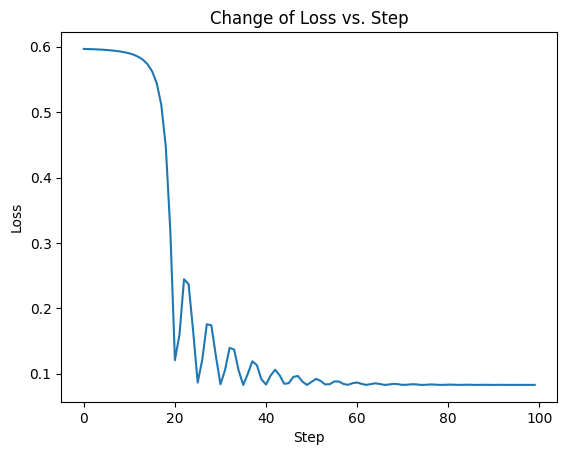

In [337]:
range_ = trange(100)
losses =[]

for step in range_:
    loss, state = step_fn(step, state)
    print(loss)
    losses.append(loss)
    range_.set_postfix(loss=f"{loss:.6f}")

plt.plot(range(100), losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Change of Loss vs. Step')
plt.show()

In [338]:
mrr_r0_opt = params_fn(state)
print(mrr_r0_opt)

30.01953


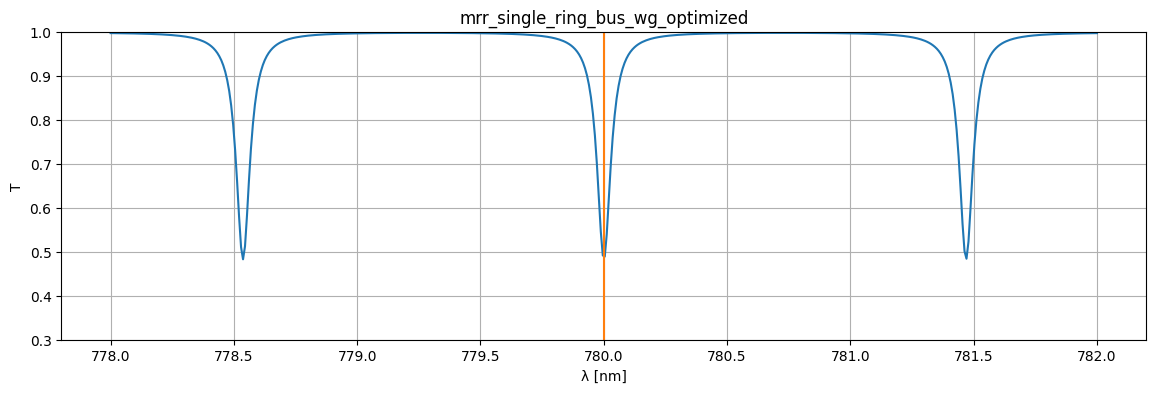

In [339]:
wl_plt = np.linspace(0.778, 0.782, num=500)
S = mrr_circuit(wl=wl_plt, bend_circular_1={"r0":mrr_r0_opt}, bend_circular_2={"r0":mrr_r0_opt}, coupler_ring_1={"gap":0.3})

plt.figure(figsize=(14, 4))
plt.title("mrr_single_ring_bus_wg_optimized")
plt.plot(1e3 * wl_plt, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(0.3, 1.0)
plt.plot([780.0, 780.0], [0, 1])
plt.grid(True)
plt.show()